In [1]:
import os
import h5py
import numpy as np

from ipywidgets import interact

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# configure matplotlib
mpl.style.use("classic")
import sys
sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")

from library import cptools as cp
from library import dspec

In [192]:
# data path
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FC_B2_AVG.h5"

# load data
with h5py.File(path, "r") as f:
    jd = f["JD"][()]
    frq = f["FRQ"][()]
    lst = f["LST"][()]
    bispec1 = f["bispec XX 1"][()]
    bispec2 = f["bispec XX 2"][()]

In [210]:
eicp1 = np.exp(1j * np.angle(bispec1))
eicp2 = np.exp(1j * np.angle(bispec2))

In [155]:
def plot(j, tr):
    im = plt.imshow(
        np.flip(np.angle(eicp[j, tr]), axis=0),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
        vmin=-np.pi,
        vmax=np.pi
    )

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("LST (h)")
    plt.ylim([min(lst), max(lst)])
    plt.title(f"JD Bin {j}, Triad {tr}")
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

interact(plot, j=(0, 1, 1), tr=(0, bispec1.shape[1]-1, 1))

interactive(children=(IntSlider(value=0, description='j', max=1), IntSlider(value=38, description='tr', max=76…

<function __main__.plot(j, tr)>

In [158]:
xps = dspec.welch(eicp[0], eicp[1], fs=10.24, nperseg=bispec1.shape[-1]//2, shift=True)
delay = dspec.delay(n=xps.shape[-1])
print(xps.shape)

(77, 47, 80)


In [211]:
eicp_diff = eicp[1] - eicp[0]
var = np.mean(np.abs(eicp_diff)**2, axis=-1)

weights = 1 / np.array([np.sqrt(np.outer(var[:, i], var[:, i])) for i in range(var.shape[1])])
weights = np.moveaxis(weights, 0, -1)

In [223]:
for i in range(weights.shape[0]):
    weights[i, i] = 0

In [217]:
print(weights.shape, xps_matrix.shape)

(77, 77, 47) (77, 77, 47, 80)


In [248]:
import imp; imp.reload(dspec)
xps_matrix = dspec.xps(eicp1[0], eicp1[1], fs=10.24)[1]
err = dspec.xps_err(eicp2, fs=10.24)
print(xps_matrix.shape, err.shape)

(77, 77, 47, 80) (3, 77, 77, 47, 80)


In [282]:
xps_avg = (np.moveaxis(xps_matrix, -1, 0) * weights).sum(axis=(1, 2, 3)) / weights.sum(axis=(0, 1, 2))
err_avg = (np.moveaxis(err, -1, 0) * weights).sum(axis=(2, 3, 4)) / weights.sum(axis=(0, 1, 2))
print(xps_avg.shape, err_avg.shape)

(80,) (80, 3)


In [278]:
power = np.mean(xps_avg, axis=-1)
error = np.mean(err_avg, axis=-1)
error = np.mean(np.abs(error), axis=-1)
print(power.shape, error.shape)

(80,) (80,)


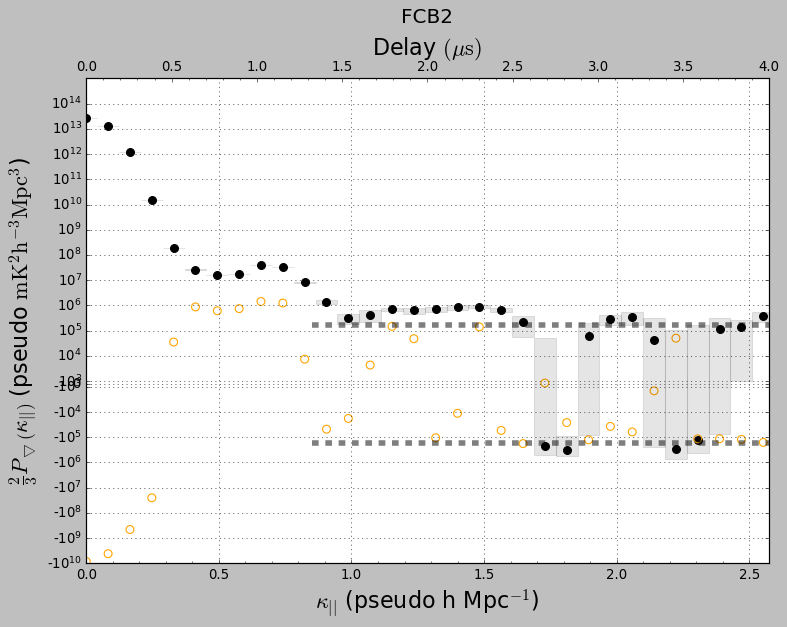

In [285]:
dspec.power_plot(
    delay,
    xps_avg * 1e12, 
    np.mean(np.abs(err_avg), axis=-1) * 1e12,
    linthresh=1e4,
    legend=False,
    onesided=True,
    title="FCB2",
)